# VGG 16 CNN

## Setup

In [1]:
import os
import sys
import numpy as np
from pathlib import Path

In [2]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: Using Google CoLab")
except:
    print("Note: Not using Google CoLab")
    COLAB = False

if COLAB:
    if not os.path.ismount("/content/drive"):
        print("Note: Mounting drive")
        drive.mount('/content/drive')
    else:
        print("Note: Drive already mounted")

    os.system("pip install pycm")
    print("Note: pycm installed")

    sys.path.append("/content/drive/MyDrive/tumorclass.info")
    sys.path.append("/content/drive/MyDrive/tumorclass.info/notebooks")

    PROJECT_PATH = "/content/drive/MyDrive/tumorclass.info"

else:
    PROJECT_PATH = str(Path.cwd().parent)

DATA_PATH = os.path.join(PROJECT_PATH, "data/")
MODELS_PATH = os.path.join(PROJECT_PATH, "models/")
DATASET_PATH = os.path.join(PROJECT_PATH, "data/dataset/")
SRC_0_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_0/")
SRC_1_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_1/")
SRC_2_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_2/")
TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/")
TRAIN_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/normal/")
TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/lgg/")
TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/hgg/")
TEST_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/")
TEST_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/normal/")
TEST_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/lgg/")
TEST_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/hgg/")
VALID_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/")
VALID_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/normal/")
VALID_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/lgg/")
VALID_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/hgg/")
AUG_TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/")
AUG_TRAIN_NORMAL_PATH = os.path.join(
    PROJECT_PATH, "data/dataset/aug_train/normal/"
)
AUG_TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/lgg/")
AUG_TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/hgg/")

try:
    TEST_NORMAL_FILES = np.array(sorted(os.listdir(TEST_NORMAL_PATH)))
    TEST_LGG_FILES = np.array(sorted(os.listdir(TEST_LGG_PATH)))
    TEST_HGG_FILES = np.array(sorted(os.listdir(TEST_HGG_PATH)))
except FileNotFoundError:
    print("Note: No test data found! Run preprocessing.ipynb first.")

Note: Not using Google CoLab


In [3]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tools.data import (
    compare_predictions,
    confusion_matrix,
    count_params,
    enumerate_oxford,
    learning_rate_scheduler,
    p_join,
    predict_gen,
    predictor,
)
from tools.file import mkdir_if_not_exists, pickler
from tools.visualize import plot_batch, plot_epochs

In [4]:
MODEL_NAME = "cnn_vgg16"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_MODE = "rgb" # "grayscale"
IMAGE_CHANNELS = 3  # 1
CLASSES = ["normal", "lgg", "hgg"]
CLASS_MODE = "categorical"
SEED = 42

BATCH_SIZE = 24

## Prepare data

In [5]:
augment = True

train_gen = ImageDataGenerator(
).flow_from_directory(
    directory=(AUG_TRAIN_PATH if augment else TRAIN_PATH),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="training",
    shuffle=True,
    seed=SEED,
)

valid_gen = ImageDataGenerator(
).flow_from_directory(
    directory=VALID_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="validation",
    shuffle=True,
    seed=SEED,
)

test_gen = ImageDataGenerator(
).flow_from_directory(
    directory=TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False,
    seed=SEED,
)

Found 1045 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [6]:
assert train_gen.n == 1045 if augment else train_gen.n == 471
assert valid_gen.n == 204
assert test_gen.n == 60
assert (
    train_gen.num_classes
    == test_gen.num_classes
    == valid_gen.num_classes
    == 3
)

In [7]:
images, labels = next(train_gen)

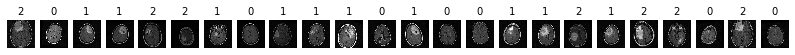

In [8]:
plot_batch(images, labels, argmax=True)

## Build Fine-tuned VGG 16 model

In [9]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

input_tensor = Input(shape=input_shape)

vgg16_model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=input_tensor,
    input_shape=input_shape,
    pooling="max",
    classes=1000,
)

model = Sequential(name="VGG16")
for layer in vgg16_model.layers[:-1]:
    layer.trainable = False
    model.add(layer)


model.add(Dense(units=3, activation="softmax", name="predictions"))

2022-01-07 18:49:44.050595: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.summary()
params = count_params(model)
# print(f"Trainable params: {params['trainable_params']:,}")
# print(f"Non-trainable params: {params['non_trainable_params']:,}")
assert params['trainable_params'] == 12_291
assert params['non_trainable_params'] == 134_260_544

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168

## Compile model

In [11]:
model.compile(
    optimizer=Adam(
        learning_rate=0.001,  # (0.001 * np.sqrt(0.1)),
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        amsgrad=False,
        name="Adam",
    ),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Fit model

In [12]:
epochs = 10

set_callbacks = [
    # "lr_schedule",
    # "lr_plateau",
    "early_stopping",
    "model_checkpoint",
]

if "lr_schedule" in set_callbacks and "lr_plateau" in set_callbacks:
    set_callbacks.pop(set_callbacks.index("lr_plateau"))
    print("Note: 'LearningRateScheduler' always wins over 'ReduceLROnPlateau'\n")

callbacks = []
callback_names = []

if set_callbacks:
    if "lr_schedule" in set_callbacks:
        learning_rate_schedule = learning_rate_scheduler(
            # epoch_steps=[5, 20],  # None,
            initial_lr=round(float(model.optimizer.learning_rate.numpy()), 8),
            # lr_steps=[0.1, 0.1],  # None,
            # use_factor=True,
            verbose=1
        )
        lr_schedule = LearningRateScheduler(learning_rate_schedule)
        model.optimizer.learning_rate = learning_rate_schedule(0)
        print(
            "[LR SCHEDULE]:\n"
            f"\tEpoch_steps: {getattr(learning_rate_schedule, 'epoch_steps')}\n"
            f"\tInitial_lr: {getattr(learning_rate_schedule, 'initial_lr')}\n"
            f"\tLr_steps: {getattr(learning_rate_schedule, 'lr_steps')}\n"
            f"\tUse_factor: {getattr(learning_rate_schedule, 'use_factor')}\n"
            )
        if getattr(learning_rate_schedule, 'use_factor'):
            epcs = getattr(learning_rate_schedule, 'epoch_steps')
            curr_step = round(float(model.optimizer.learning_rate.numpy()), 8)
            print(str(f"\tEpoch 0: {curr_step:.10f}").rstrip("0"))
            for i, step in enumerate(getattr(learning_rate_schedule, 'lr_steps')):
                curr_step *= step
                print(str(f"\tEpoch {epcs[i]}: {curr_step:.10f}").rstrip("0"))
            print()

        callbacks.append(lr_schedule)
        callback_names.append("lr_schedule")

    if "lr_plateau" in set_callbacks:
        lr_plateau = ReduceLROnPlateau(
            monitor="val_loss",
            factor=np.sqrt(0.1),
            patience=3,
            verbose=1,
            mode="auto",
            # min_delta=0.01,
            cooldown=0,
            min_lr=0.5e-6,
        )
        callbacks.append(lr_plateau)
        callback_names.append("lr_plateau")

    if "early_stopping" in set_callbacks:
        early_stopping = EarlyStopping(
            monitor="val_loss",
            # min_delta=0.01,
            patience=6,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        callbacks.append(early_stopping)
        callback_names.append("early_stopping")

    if "model_checkpoint" in set_callbacks:
        model_checkpoint = ModelCheckpoint(
            filepath=p_join(MODELS_PATH, MODEL_NAME + "_" + "checkpoint.hdf5"),
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            options=None,
        )
        callbacks.append(model_checkpoint)
        callback_names.append("model_checkpoint")

print(f"Selected callbacks: {enumerate_oxford(callback_names)}")

Selected callbacks: early_stopping, model_checkpoint


In [13]:
TRAIN_STEPS_PER_EPOCH = int(train_gen.n / BATCH_SIZE)
VALID_STEPS_PER_EPOCH = int(valid_gen.n / BATCH_SIZE)
print("Train steps per epoch:", TRAIN_STEPS_PER_EPOCH)
print("Valid steps per epoch:", VALID_STEPS_PER_EPOCH)

Train steps per epoch: 43
Valid steps per epoch: 8


In [14]:
model_operation = "load"

mkdir_if_not_exists(MODELS_PATH)

clear_session()

if model_operation == "fit":
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        validation_data=valid_gen,
        validation_steps=VALID_STEPS_PER_EPOCH,
        verbose=2,
        callbacks=callbacks if len(callbacks) > 0 else None,
        # workers=2,
    )

    save_model(model, os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))

    # save model history
    pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"),
        "save",
        history,
    )

elif model_operation == "load":
    model = load_model(os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))
    history = pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"), "load"
    )

elif model_operation == "checkpoint":
    model = load_model(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_checkpoint.hdf5")
    )
    history = None

## Predict

In [15]:
predictions, y_pred, y_true, target_names = predict_gen(model=model, gen=test_gen)

3/3 [==============================] - 8s 2s/step


In [16]:
predictions[0:5]

array([[9.9798250e-01, 7.8940170e-04, 1.2281577e-03],
       [9.9484670e-01, 2.7818598e-03, 2.3713794e-03],
       [8.9181697e-01, 9.6835203e-02, 1.1347878e-02],
       [9.4837850e-01, 1.1287347e-02, 4.0334143e-02],
       [9.9709594e-01, 2.7630953e-03, 1.4096887e-04]], dtype=float32)

In [17]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2])

In [18]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [19]:
target_names

['normal', 'lgg', 'hgg']

In [20]:
compare_predictions(y_pred, y_true, target_names)

[normal]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

[lgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 1  1  1  1  1  1  1  1  X  1  1  1  X  1  X  1  1  1  1  1 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

[hgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  X  2  2 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 



In [21]:
print(f"normal: {TEST_NORMAL_FILES[5]}")
print(f"lgg: {TEST_LGG_FILES[8]}")
print(f"hgg: {TEST_HGG_FILES[17]}")

normal: 14.jpg
lgg: 29.jpg
hgg: 58.jpg


In [22]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "normal", "14.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: NORMAL with 45.27% confidence.

Ratio
Normal: 45.27%
LGG: 14.18%
HGG: 40.56%


In [23]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "lgg", "29.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: HGG with 99.72% confidence.

Ratio
Normal: 0.00%
LGG: 0.28%
HGG: 99.72%


In [24]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "hgg", "58.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: LGG with 93.44% confidence.

Ratio
Normal: 0.00%
LGG: 93.44%
HGG: 6.56%


## Evaluate

In [25]:
eval_loss, eval_accuracy = model.evaluate(
    x=test_gen,
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"Evaluation loss: {eval_loss:.2f}")
print(f"Evaluation accuracy: {eval_accuracy*100:.2f}%")

3/3 [==============================] - 9s 3s/step - loss: 0.3218 - accuracy: 0.9333
Evaluation loss: 0.32
Evaluation accuracy: 93.33%


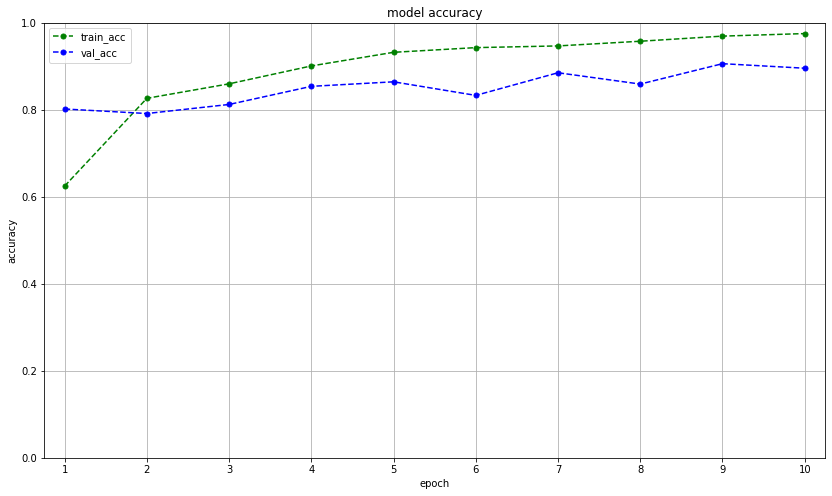

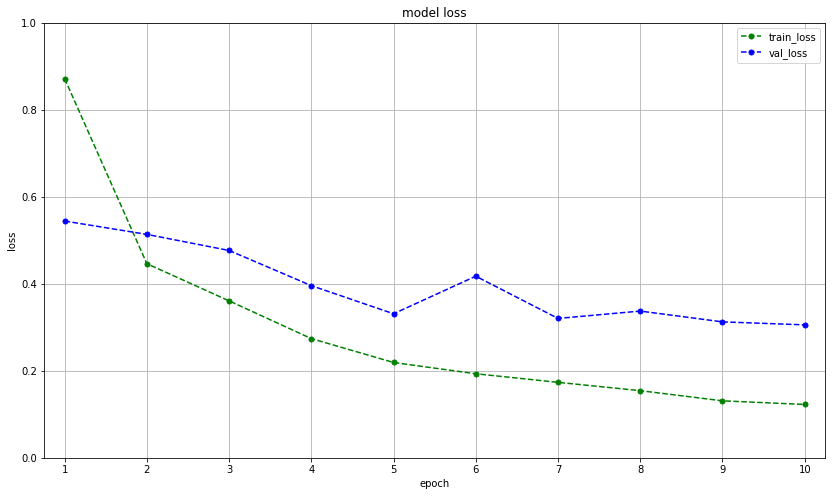

In [26]:
if history is not None:
    plot_epochs(history=history, filepath=f"{MODELS_PATH}{MODEL_NAME}")

In [27]:
cm = confusion_matrix(
    y_pred=y_pred,
    y_true=y_true,
    labels=CLASSES,
    save=True,
    path=MODELS_PATH,
    file_name=MODEL_NAME,
)

In [28]:
cm.imbalance

False

In [29]:
# print four lines. Justify text after colon
print(
    f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}\n"
    f"{cm.Overall_ACC*100:<10.2f} {cm.PPV_Macro:<10.2f}"
    f"{cm.TPR_Macro:<10.2f} {cm.F1_Macro:<10.2f}"
)

Accuracy   Precision  Recall     F1 Score  
93.33      0.93      0.93       0.93      


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

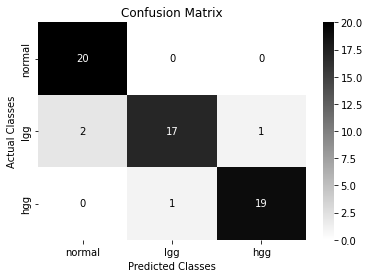

In [30]:
cm.plot(plot_lib = "seaborn", number_label=True)

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

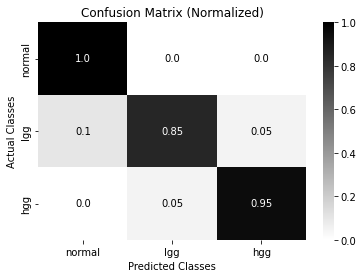

In [31]:
cm.plot(plot_lib = "seaborn", number_label=True, normalized=True)

In [32]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names))


Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.93
Macro Recall: 0.93
Macro F1-score: 0.93

Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1-score: 0.93

Classification Report

              precision    recall  f1-score   support

      normal       0.91      1.00      0.95        20
         lgg       0.94      0.85      0.89        20
         hgg       0.95      0.95      0.95        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60

